Progress report: Unsupervised clustering of reads from two different sequences
================================================================================


A few months ago, I was assigned the task of clustering reads. This document sums my attempts to solve this problem, including the methods and thier results.

Definition of the problem:
--------------------------

We have Fast5 files containing information, that includes the raw signal and the events, about reads coming from two different DNA sequences. Our goal is to cluster them using unsupervised methods. This means separating the reads into two groups according to the sequence they were generated from withut explicitly labeling them for the computer. This significantly Hardens the task, since the most successful machine learning algorithms to date have been supervised.

First approach - Clustering via DTW
-----------------------------------

DTW (Dynamic Time Warping, [orignal text](https://www.aaai.org/Papers/Workshops/1994/WS-94-03/WS94-03-031.pdf)) is an algorithm that serves as a distance measure and creates an alignment between two time series. It is widely used in time series analysis, and hence has a multitude of variations and results based on it.

Two give some intuition on how it works let us analyze this image:

![title](https://ars.els-cdn.com/content/image/1-s2.0-S0169743916303732-gr2.jpg)

DTW creates an aligment between the points of two time series (where a time series is defined is defined classicaly as $X(t)=[x_{0}, x_{1}...x_{n}]$ with $t(x_{n+1})-t(x_{n})=const$ ) such as the sum of the distance of the aligned point is the minimum.
This means the DTW take into account phase shifts and two a certain extent amplitude and length difference between the time serieses, as we can see above. This makes it theoritically suitable to be used on our messy time series data.

The known approach to clustering time series based on DTW is DBA (DTW Barycenter Averaging [original text](https://www.researchgate.net/publication/220601732_A_global_averaging_method_for_dynamic_time_warping_with_applications_to_clustering)) which is effectively the K-means algorithm using DTW. However this technique relies on same length time series, which we dont have. It is possible to solve this by interlopating the time series as shown by this paper on DTW qualities: [paper]().

Implementation:
---------------

I have knowledge in programming python, so that was my language of focus. There is one significant time series package called tslearn, which has a DBA function built in. However I found their implementation two slow, as it took about eight hours two finish running on 40 raw signals total, 20 from each sequence. In addition, the results were inconclusive, as the prediction were as good as guessing. I set on programming an more efficient implementation. I did so with these methods:

1. Use FasDTW instead of DTW. FastDTW ([original paper](https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf)) is an algorithm which approximates DTW with $O(n)$ time complexity instead of $O(n^2)$.

2. Using packages that speed up python. Not mentioning the obvious tool for numerical computing that is numpy, there also two important option for *compiling* python, even though it is an interpeted language. The first option is Cython, not to be confused with Cpython, which is a superset of python that allows compiling python to c files and allows for C like syntax to make the compiling more efficient. The second one is numba, which is a jit (just in time) compiler for python based on [llvm](https://llvm.org/). It's syntax is easier than Cython, however it is harder to debug sometimes and I recommend it only for relatively short code.  

3. Using a fast cython based implementaion of FastDTW in python called fastdtw.

I wrote a version based on numba, cython, and normal python and cython. On average, the python version is the fastest version however I'm sure more can be done to improve the other versions.
In total this manged to speed up the program by 20 to 40 to times over the original, which also used cython and numpy. This is comparable to c speeds. This is the code and documentation for the python version:

In [ ]:
from fastdtw import fastdtw
import numpy as np
import matplotlib.pyplot as plt
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.preprocessing import TimeSeriesResampler
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils import check_random_state
import timeit
import time

def medoid(D):
    '''
    Find medoid of database D, which is an ndarray, each row is a timeseries. does so in O(n^2)
    '''
    
    #compute distance matrix
    n=D.shape[0]
    dist_matrix=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            #t1=time.perf_counter()
            dist_matrix[i,j]=fastdtw(D[i],D[j])[0]
            #print (time.perf_counter()-t1)
    dist_matrix=np.maximum(dist_matrix,dist_matrix.T)

    #check for mediod
    med=D[np.argmin(np.sum(dist_matrix,axis=1))]
    return med

def s_contrib(center,s):
    '''
    Contribution of timeseries/signal s to barycenter center. Works with FDBA_update, as the first row of the center_matrix is the sum of 
    the first row of all contributions.
    '''

    alignment=np.array(fastdtw(center,s)[1])
    contrib=np.zeros((center.shape[0],2))

    for i in range(center.shape[0]):
        i_contrib=alignment[alignment[:,0]==i][:,1]
        contrib[i,0]=np.sum(s[i_contrib])
        contrib[i,1]=i_contrib.shape[0]

    return contrib

def FDBA_update(center_matrix):
    '''
    Update barycenter according to the center_matrix. The center_matrix is an ndarray with shape=(2,length of center), the barycenter is calculated
    as center[i]=center_matrix[0]/center_matrix[1]
    '''
    
    return np.divide(center_matrix[:,0],center_matrix[:,1])

def FDBA(D,n_iterations=10,verbose=False):
    '''
    Fast DTW barycenter averaging full algorithm. n_iteration tells how many times to update center. If verbose is True, 
    prints number of current iteration.
    '''
    center=medoid(D)#initializing center as mediod

    for i in range(n_iterations):
        if verbose:
            print ("FDBA iteration: "+str(i+1))
        new_center=np.zeros((center.shape[0],2))
        for s in D:
            new_center=np.add(new_center,s_contrib(center,s))
        center=FDBA_update(new_center)

    return center

def assign(centers,D):
    '''
    Assigns labels to timeseries in D according to barycenters centers, kmeans style, with distance metric FDTW. 
    '''
    dists=np.zeros((D.shape[0],centers.shape[0]))

    for i in range(D.shape[0]):
        for j in range(centers.shape[0]):
            dists[i,j]=fastdtw(D[i],centers[j])[0]
    matched_labels=dists.argmin(axis=1)

    return matched_labels

def FDBA_clustering(D,n_iterations=10,k=2,verbose=False):
    '''
    Full algorithm. D is an jagged ndarray, representing different length time series. n_iteration tells how many times to update center. k is the
    number of barycenters. If verbose is True, prints number of current iteration.
    '''
    sz=np.max(np.array(list(map(lambda s: len(s),D))))
    D=TimeSeriesResampler(sz=sz).fit_transform(D)
    D=np.squeeze(D)
    D_squared_norms=(D * D).sum(axis=1)
    centers=_k_init(D,k,D_squared_norms,check_random_state(None))

    for i in range(n_iterations):
        if verbose:
            print ("Clustering iteration: "+str(i+1))
        matched_labels=assign(centers,D)
        for j in range(len(centers)):
            centers[j]=FDBA(D[matched_labels==j],verbose=verbose)

    return centers


Result:
-------

After running the program 3 days straight on 120 raw signals, evenly split between the sequences, the results where not good at all, as seen in these cells:

In [ ]:
#if you want zoomable and interactive graphs, run this cell
%matplotlib widgets

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from dtw_stuff import FDBA as fdba

C:\Users\Elad\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Reading 30 signals from each directory. Each directory contains 30 reads from passes and fail's of both barcodes.

In [108]:
#30 files in each pass fail

t1=[]#barcode2 signals
t2=[]#barcode2 signals

path1='./Fast5_files_30_each/pass/barcode1'
path2='./Fast5_files_30_each/fail/barcode1'
path3='./Fast5_files_30_each/pass/barcode2'
path4='./Fast5_files_30_each/fail/barcode2'

def find_read(name):
    #Find all Signals
    if 'Signal' in name:
        return 'Raw/Reads/'+name

for name in os.listdir(path1):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path1,name),'r')
        t1.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))
    
for name in os.listdir(path2):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path2,name),'r')
        t1.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))

for name in os.listdir(path3):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path3,name),'r')
        t2.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))

for name in os.listdir(path4):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path4,name),'r')
        t2.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))

D1=np.array(t1)
D2=np.array(t2)
D=np.array(t1+t2)

Plotting data:

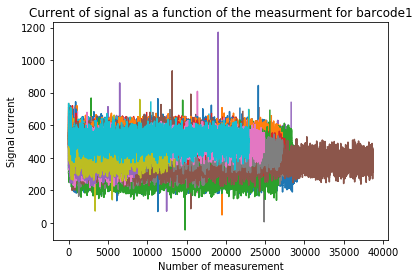

In [109]:
plt.figure()
for s in D1:
    plt.plot(range(s.shape[0]),s)

plt.title("Current of signal as a function of the measurment for barcode1")
plt.xlabel("Number of measurement")
plt.ylabel("Signal current")
plt.show()

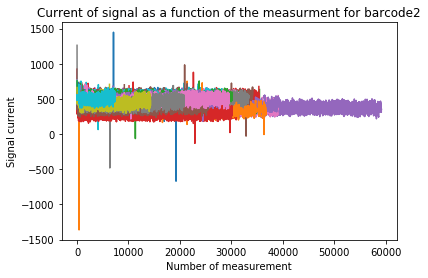

In [110]:
plt.figure()
for s in D2:
    plt.plot(range(s.shape[0]),s)

plt.title("Current of signal as a function of the measurment for barcode2")
plt.xlabel("Number of measurement")
plt.ylabel("Signal current")
plt.show()

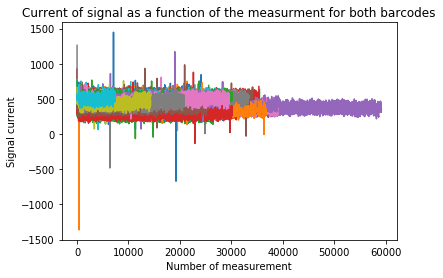

In [111]:
plt.figure()
for s in D:
    plt.plot(range(s.shape[0]),s)

plt.title("Current of signal as a function of the measurment for both barcodes")
plt.xlabel("Number of measurement")
plt.ylabel("Signal current")
plt.show()

Loading the centers that are the result of FDBA on data from hardrive, and assigning labels:

In [48]:
centers=np.loadtxt("centers.csv", delimiter=",")

In [123]:
labels=fdba.assign(centers,D)#just wrong, supposed to be all ones and then all zeros or vice-versa
print (labels)

[0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0
 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1]


Conclusion:
-----------

I'm not sure this technique doesnt work, considering the I only tried clustering 120 signals at once, and the fact that maybe running the code longer would have created better results, however i dont think this is the right approach, since even with a significant speedup of the code with pararell computing and a rewrite in efficient c, to cluster large clusters of hundred of reads you would need a lot of time to iterate over the code. The most important take away is the need to work with the data in a way that wont require heavy computational work.

Plotting the data
------------------
One way of avoiding the heavy computational work is to extract features from the time serieses, for example mean of the time series, and work with that.
In accordance to this, I was asked to create histograms of the event means of the reads. Here are the results:

In [112]:
from scipy.interpolate import interp1d

In [129]:
#event important things: mean is in position 0, var in position 3

Reading all events from each directory. Each directory contains reads from passes and fail's of both barcodes.

In [113]:
#All events on fast5 files on computer

t1=[]#barcode2 reads
t2=[]#barcode2 reads

path1='./Fast5_files/pass/barcode1'
path2='./Fast5_files/fail/barcode1'
path3='./Fast5_files/pass/barcode2'
path4='./Fast5_files/fail/barcode2'

for name in os.listdir(path1):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path1,name),'r')
        t1.append(np.array(f.get('/Analyses/Basecall_1D_001/BaseCalled_template/Events')))
    
for name in os.listdir(path2):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path2,name),'r')
        t1.append(np.array(f.get('/Analyses/Basecall_1D_001/BaseCalled_template/Events')))

for name in os.listdir(path3):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path3,name),'r')
        t2.append(np.array(f.get('/Analyses/Basecall_1D_001/BaseCalled_template/Events')))

for name in os.listdir(path4):
    if name!='.ipynb_checkpoints':
        f=h5py.File(os.path.join(path4,name),'r')
        t2.append(np.array(f.get('/Analyses/Basecall_1D_001/BaseCalled_template/Events')))

D1=np.array(t1)
D2=np.array(t2)
D=np.array(t1+t2)

In [114]:
#parameters for consistent graphs

xmin,xmax=50,180
ymin,ymax=0,0.1

In [115]:
#getting event means 

event_means1=[]
event_means2=[]

for read in D1:
    means=[]
    for j in range(read.shape[0]):
            means.append(read[j][0])
    event_means1.append(np.array(means))

for read in D2:
    means=[]
    for j in range(read.shape[0]):
            means.append(read[j][0])
    event_means2.append(np.array(means))
    
event_means1=np.array(event_means1)
event_means2=np.array(event_means2)

Plotting data:

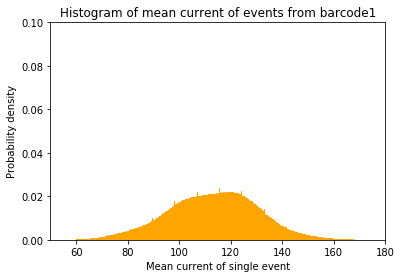

In [116]:
fig=plt.figure()
flat_events1=np.hstack(event_means1)
#normed_data,xmin_t,xmax_t=norm_pdf_hist(flat_events1,bins=1000,xlims=(xmin,xmax)) remember to change to normed_data
plt.hist(flat_events1,bins=1000, density=True,color='orange')
plt.title("Histogram of mean current of events from barcode1")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Mean current of single event')
plt.show()

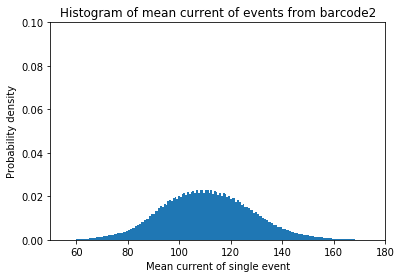

In [117]:
event_means2=np.array(event_means2)
fig=plt.figure()
flat_events2=np.hstack(event_means2)
#normed_data,xmin_t,xmax_t=norm_pdf_hist(flat_events2,bins=1000,xlims=(xmin,xmax)) remember to change to normed_data
plt.hist(flat_events2,bins=1000, density=True)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.title("Histogram of mean current of events from barcode2")
plt.ylabel('Probability density')
plt.xlabel('Mean current of single event')
plt.show()

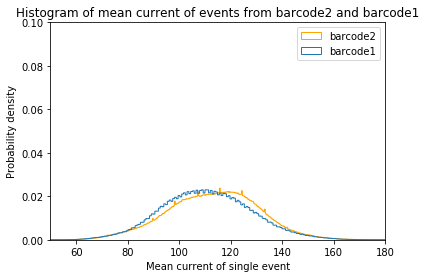

In [118]:
fig=plt.figure()
o1=plt.hist(flat_events1,bins=1000,density=True,histtype=u'step',label='barcode1',color='orange')
o2=plt.hist(flat_events2,bins=1000,density=True,histtype=u'step',label='barcode2')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.title("Histogram of mean current of events from barcode2 and barcode1")
plt.ylabel('Probability density')
plt.xlabel('Mean current of single event')
plt.legend(('barcode2','barcode1'))
plt.show()

As it is possible to see, the histograms look like normal distributions however they have different skewedness and kurtosis ([third and fourth moments](https://en.wikipedia.org/wiki/Moment_(mathematics)). I tried to cluster the reads by fitting a distribution characterized by the mean, variance and skewedness ([as defined here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html)) to the event means of a read and then applying K-means. It didn't work.

To understand why i created these interactive plots:

In [119]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [120]:
plt.figure()

def f(i,t):
    plt.cla()
    events=event_means1[i-1]
    plt.hist(events[:t],bins=1000,density=True,color='orange')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title("Histogram of mean current of events from read i in barcode1 until read t")
    plt.ylabel('Probability density')
    plt.xlabel('Mean current of single event')

i_widget=widgets.IntSlider(min=1,max=event_means1.shape[0],step=1,value=1)
t_widget=widgets.IntSlider(min=1,max=event_means1[0].shape[0],step=100,value=1)

def update_t_range(*args):
    t_widget.max = event_means1[i_widget.value-1].shape[0]
    
i_widget.observe(update_t_range, 'value')

interact(f,i=i_widget,t=t_widget)

plt.show()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=1, description='i', max=760, min=1), IntSlider(value=1, description='t',…

In [121]:
plt.figure()

def f(i,t):
    plt.cla()
    events=event_means2[i-1]
    plt.hist(events[:t],bins=1000,density=True)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title("Histogram of mean current of events from read i in barcode2 until read t")
    plt.ylabel('Probability density')
    plt.xlabel('Mean current of single event')

i_widget=widgets.IntSlider(min=1,max=event_means2.shape[0],step=1,value=1)
t_widget=widgets.IntSlider(min=1,max=event_means2[0].shape[0],step=100,value=1)

def update_t_range(*args):
    t_widget.max = event_means2[i_widget.value-1].shape[0]
    
i_widget.observe(update_t_range, 'value')

interact(f,i=i_widget,t=t_widget)

plt.show()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=1, description='i', max=757, min=1), IntSlider(value=1, description='t',…

It can be seen that the histograms vary a lot between each read, hence the method wasn't effective.
I did the same for variance of event means:

In [122]:
#getting variance of events

event_variance1=[]
event_variance2=[]

for read in D1:
    means=[]
    for j in range(read.shape[0]):
            means.append(read[j][0])
    event_variance1.append(np.var(means))

for read in D2:
    means=[]
    for j in range(read.shape[0]):
            means.append(read[j][0])
    event_variance2.append(np.var(means))
    
event_variance1=np.array(event_variance1)
event_variance2=np.array(event_variance2)

In [123]:
#parameters for consistent graphs

xmin,xmax=110,200

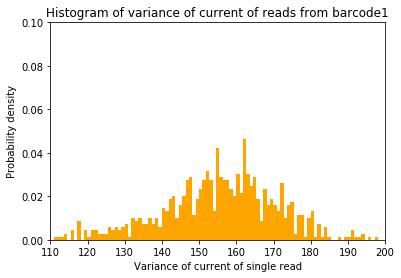

In [124]:
fig=plt.figure()
flat_events1=np.hstack(event_variance1)
plt.hist(flat_events1,bins=100, density=True,color='orange')
plt.title("Histogram of variance of current of reads from barcode1")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Variance of current of single read')
plt.show()

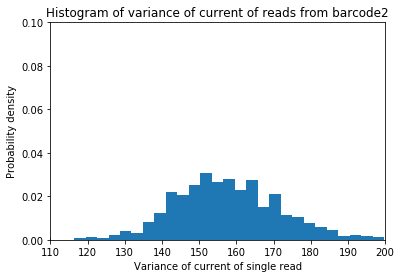

In [125]:
fig=plt.figure()
flat_events2=np.hstack(event_variance2)
plt.hist(flat_events2,bins=100, density=True)
plt.title("Histogram of variance of current of reads from barcode2")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Variance of current of single read')
plt.show()

In [126]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

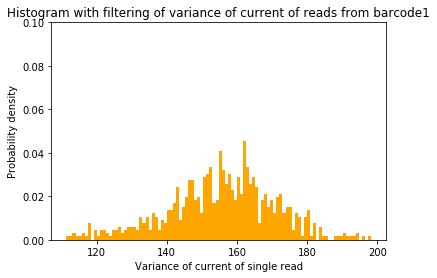

In [127]:
fig=plt.figure()
flat_events1=np.hstack(event_variance1)
filtered1=flat_events1[~is_outlier(flat_events1)]
plt.hist(filtered1,bins=100, density=True,color='orange')
plt.title("Histogram with filtering of variance of current of reads from barcode1")
#plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Variance of current of single read')
plt.show()

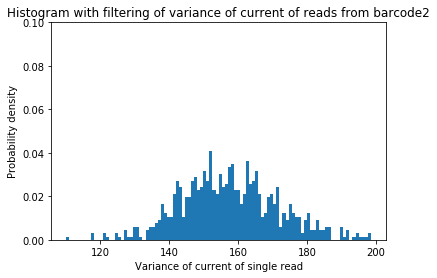

In [128]:
fig=plt.figure()
flat_events2=np.hstack(event_variance2)
filtered2=flat_events2[~is_outlier(flat_events2)]
plt.hist(filtered2,bins=100, density=True)
plt.title("Histogram with filtering of variance of current of reads from barcode2")
#plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Variance of current of single read')
plt.show()

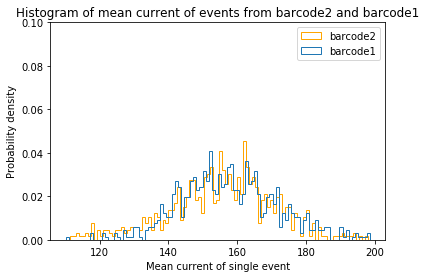

In [129]:
fig=plt.figure()
o1=plt.hist(filtered1,bins=100,density=True,histtype=u'step',label='barcode1',color='orange')
o2=plt.hist(filtered2,bins=100,density=True,histtype=u'step',label='barcode2')
#plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.title("Histogram of mean current of events from barcode2 and barcode1")
plt.ylabel('Probability density')
plt.xlabel('Mean current of single event')
plt.legend(('barcode2','barcode1'))
plt.show()

And the raw signal:

Reading signals from each directory. Each directory contains reads from passes and fail's of both barcodes.

In [130]:
#All signals on fast5 files on computer

t1=[]#barcode2 signals
t2=[]#barcode2 signals

path1='./Fast5_files/pass/barcode1'
path2='./Fast5_files/fail/barcode1'
path3='./Fast5_files/pass/barcode2'
path4='./Fast5_files/fail/barcode2'

def find_read(name):
    #Find all Signals
    if 'Signal' in name:
        return 'Raw/Reads/'+name

n=0
for name in os.listdir(path1):
    if name!='.ipynb_checkpoints':
        n+=1
        f=h5py.File(os.path.join(path1,name),'r')
        t1.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))
print ("Number of barcode1 pass: "+str(n))

n=0
for name in os.listdir(path2):
    if name!='.ipynb_checkpoints':
        n+=1
        f=h5py.File(os.path.join(path2,name),'r')
        t1.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))
print ("Number of barcode1 fail: "+str(n))

n=0
for name in os.listdir(path3):
    if name!='.ipynb_checkpoints':
        n+=1
        f=h5py.File(os.path.join(path3,name),'r')
        t2.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))
print ("Number of barcode2 pass: "+str(n))

n=0
for name in os.listdir(path4):
    if name!='.ipynb_checkpoints':
        n+=1
        f=h5py.File(os.path.join(path4,name),'r')
        t2.append(np.array(f.get(f.get('Raw/Reads').visit(find_read))))
print ("Number of barcode2 fail: "+str(n))
    
S1=np.array(t1)
S2=np.array(t2)
S=np.array(t1+t2)

Number of barcode1 pass: 380
Number of barcode1 fail: 380
Number of barcode2 pass: 378
Number of barcode2 fail: 379


Plotting data:

In [131]:
#parameters for consistent graphs

xmin,xmax=200,600
ymin,ymax=0,0.02

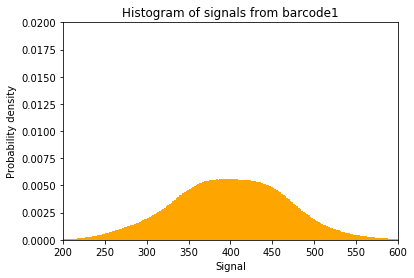

In [132]:
fig=plt.figure()
flat_S1=np.hstack(S1)
plt.hist(flat_S1,bins=4095, density=True,color='orange')#check with them wtf is happening with bins
plt.title("Histogram of signals from barcode1")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Signal')
plt.show()

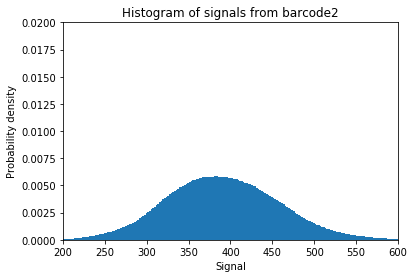

In [133]:
fig=plt.figure()
flat_S2=np.hstack(S2)
plt.hist(flat_S2,bins=4095, density=True)#check with them wtf is happening with bins
plt.title("Histogram of signals from barcode2")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Signal')
plt.show()

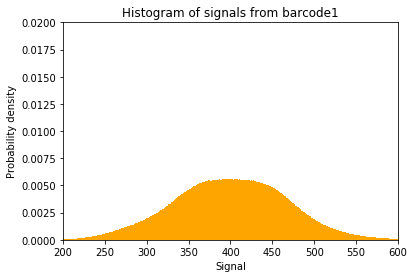

In [134]:
fig=plt.figure()
flat_S1=np.hstack(S1)
filtered1=flat_S1[~is_outlier(flat_S1)]
plt.hist(filtered1,bins=475, density=True,color='orange')
plt.title("Histogram of signals from barcode1")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Signal')
plt.show()

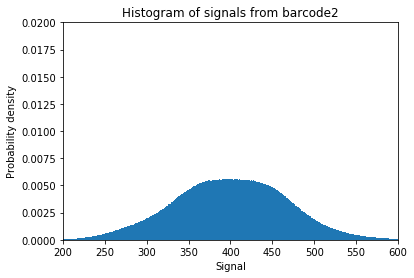

In [135]:
fig=plt.figure()
flat_S2=np.hstack(S2)
filtered2=flat_S2[~is_outlier(flat_S2)]
plt.hist(filtered1,bins=475, density=True)
plt.title("Histogram of signals from barcode2")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.ylabel('Probability density')
plt.xlabel('Signal')
plt.show()

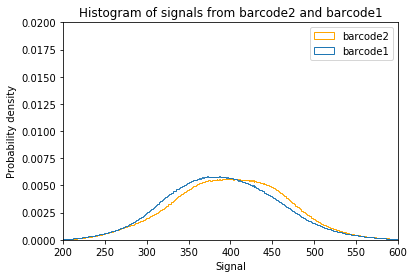

In [136]:
fig=plt.figure()
plt.hist(filtered1,bins=475,density=True,histtype=u'step',label='barcode1',color='orange')
plt.hist(filtered2,bins=475,density=True,histtype=u'step',label='barcode2')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.title("Histogram of signals from barcode2 and barcode1")
plt.ylabel('Probability density')
plt.xlabel('Signal')
plt.legend(('barcode2','barcode1'))
plt.show()

Second approach - Extracting features
-------------------------------------

After realizing that examining features one by one is a waste of time, I used the python package [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/introduction.html) to extract 789 features who aren't computaitionally heavy ([detailed here](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html)). After calclulating the features, I tried clustering them with various algorithms (listed below) with above average but not sufficient success.

Implementation and Results:
------------------------

In [171]:
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN,SpectralClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix

Extracting the features (Do not run, takes long time):

In [138]:
ids1=[]
ids2=[]

for i in range(S1.shape[0]):
    ids1.append(np.full(S1[i].shape[0],i))
    
for i in range(S2.shape[0]):
    ids2.append(np.full(S2[i].shape[0],i))

ids1=np.concatenate(ids1)
ids2=np.concatenate(ids2)

In [139]:
time1=[]
time2=[]

for s in S1:
    time1.append(np.arange(s.shape[0]))
    
for s in S2:
    time2.append(np.arange(s.shape[0]))
    
time1=np.concatenate(time1)
time2=np.concatenate(time2)

In [140]:
S1_df=pd.DataFrame({'id':ids1,
                    'Time':time1,
                    'Signal':flat_S1})

S2_df=pd.DataFrame({'id':ids2,
                    'Time':time2,
                    'Signal':flat_S2})

In [64]:
S1_df.columns,S2_df.columns

(Index(['id', 'Time', 'Signal'], dtype='object'),
 Index(['id', 'Time', 'Signal'], dtype='object'))

In [24]:
extraction_settings = tsfresh.feature_extraction.EfficientFCParameters()

In [17]:
features1 = tsfresh.extract_features(S1_df, 
                     column_id='id', column_sort='Time',
                     default_fc_parameters=extraction_settings,
                     impute_function=tsfresh.utilities.dataframe_functions.impute
)

Feature Extraction: 100%|██████████| 10/10 [2:29:56<00:00, 665.73s/it]


In [25]:
features2 = tsfresh.extract_features(S2_df, 
                     column_id='id', column_sort='Time',
                     default_fc_parameters=extraction_settings,
                     impute_function=tsfresh.utilities.dataframe_functions.impute
)

Feature Extraction: 100%|██████████| 10/10 [2:46:39<00:00, 936.52s/it]


Saving the features (Do not run, unless your sure you want to save features as they currently are):

In [79]:
#features1.to_csv('./Features1.csv')

In [27]:
#features2.to_csv('./Features2.csv')

Reading the saved features from memory, and turning them into easy to work with ndarray:

In [141]:
features1=pd.read_csv('./Features1.csv')

In [142]:
features2=pd.read_csv('./Features2.csv')

In [143]:
features1.shape,features2.shape

((760, 789), (757, 789))

In [144]:
F=np.vstack((features1.values,features2.values))

Creating the [scaled](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) data:

In [145]:
scaler2=StandardScaler()

scaler2.fit(F)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [146]:
scaler=StandardScaler()
scaled_F=scaler.fit_transform(F)

Calculating means of scaled data:

In [147]:
scaled_mean1=np.mean(scaled_F[:760],axis=0)
scaled_mean2=np.mean(scaled_F[760:],axis=0)

Plotting data:

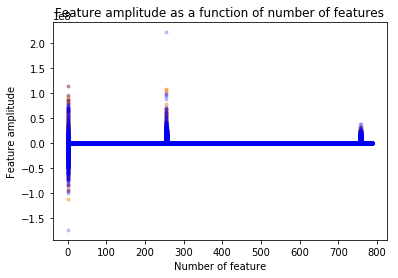

In [148]:
plt.figure()

plt.title("Feature amplitude as a function of number of features")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(np.broadcast_to(np.arange(F.shape[1]),(760,F.shape[1])),F[:760],'C1.',alpha=0.4)
plt.plot(np.broadcast_to(np.arange(F.shape[1]),(757,F.shape[1])),F[760:],'b.',alpha=0.2)
plt.show()

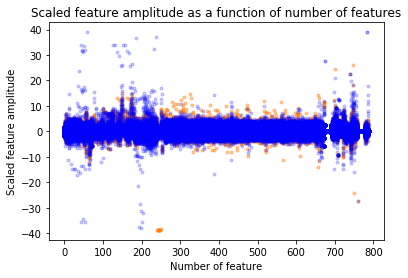

In [149]:
plt.figure()

plt.title("Scaled feature amplitude as a function of number of features")
plt.ylabel("Scaled feature amplitude")
plt.xlabel("Number of feature")
plt.plot(np.broadcast_to(np.arange(scaled_F.shape[1]),(760,scaled_F.shape[1])),scaled_F[:760],'C1.',alpha=0.4)
plt.plot(np.broadcast_to(np.arange(scaled_F.shape[1]),(757,scaled_F.shape[1])),scaled_F[760:],'b.',alpha=0.2)
plt.show()

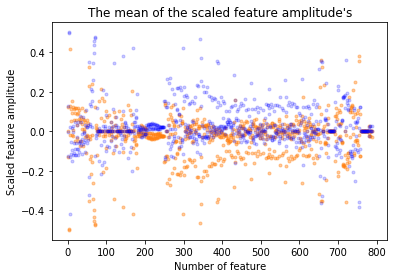

In [150]:
plt.figure()

plt.title("The mean of the scaled feature amplitude's")
plt.ylabel("Scaled feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

[K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) on normal data:

In [151]:
kmeans=KMeans(n_clusters=2)

kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [152]:
kmeans.cluster_centers_

array([[ 3.80714286e+02, -2.98492714e+07,  3.93892649e+05, ...,
         0.00000000e+00,  2.42519171e+03,  1.00000000e+00],
       [ 3.77247963e+02,  1.31966071e+07,  3.12138923e+05, ...,
         0.00000000e+00,  2.45447766e+03,  1.00000000e+00]])

Accuracy of prediction in probabilities:

In [153]:
prob1=np.sum(kmeans.predict(F[:760]))/760
prob2=1-np.sum(kmeans.predict(F[760:]))/757

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
else:
    print (1-prob1,1-prob2)

0.6381578947368421 0.5059445178335535


Plotting K-means centers:

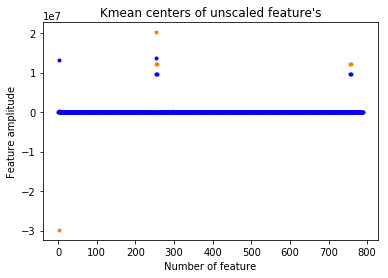

In [154]:
plt.figure()

plt.title("Kmean centers of unscaled feature's")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(kmeans.cluster_centers_.shape[1]),kmeans.cluster_centers_[0],'C1.')
plt.plot(range(kmeans.cluster_centers_.shape[1]),kmeans.cluster_centers_[1],'b.')
plt.show()

[K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) on scaled data:

In [155]:
scaled_kmeans=KMeans(n_clusters=2)
scaled_kmeans.fit(scaled_F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [156]:
scaled_kmeans.cluster_centers_

array([[ 0.21655683,  0.11044975, -1.20539608, ...,  0.        ,
         0.24616484,  0.        ],
       [-0.08932465, -0.04555795,  0.49719783, ...,  0.        ,
        -0.10153727,  0.        ]])

Accuracy of prediction in probabilities, and finding corresponding centers to groups:

In [157]:
center1=None
center2=None

prob1=np.sum(scaled_kmeans.predict(scaled_F[:760]))/760
prob2=1-np.sum(scaled_kmeans.predict(scaled_F[760:]))/757

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=scaled_kmeans.cluster_centers_[1]
    center2=scaled_kmeans.cluster_centers_[0]
else:
    print (1-prob1,1-prob2)
    center1=scaled_kmeans.cluster_centers_[0]
    center2=scaled_kmeans.cluster_centers_[1]

0.34078947368421053 0.7569352708058125


Plotting data:

In [158]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

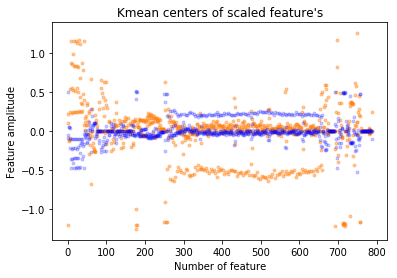

In [159]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean centers of scaled feature's")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

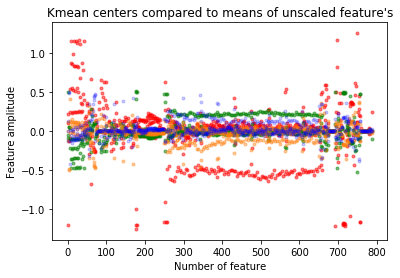

In [160]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean centers compared to means of unscaled feature's")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

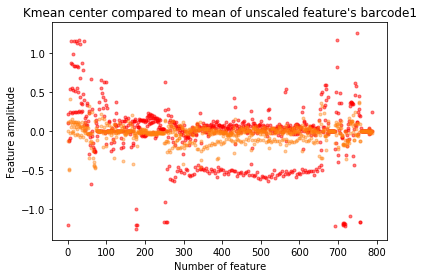

In [161]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean center compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.show()

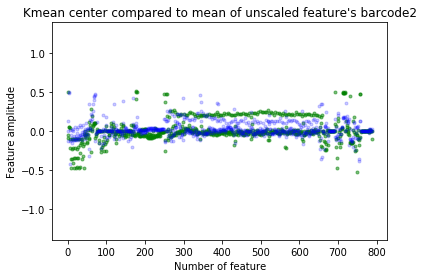

In [162]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean center compared to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

[DBscan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), an unsupervised clustering algorithm based on finding dense clusters and the "vacums" between them, on scaled data:

In [163]:
dbscan=DBSCAN(eps=25)
dbscan.fit(scaled_F)

DBSCAN(algorithm='auto', eps=25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Accuracy of prediction in probabilities, and calculating corresponding centers:

In [164]:
center1=None
center2=None

prob1=np.sum(dbscan.labels_[:760])/760*-1
prob2=1-np.sum(dbscan.labels_[760:])/757*-1

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=np.mean(scaled_F[dbscan.labels_==1],axis=0)
    center2=np.mean(scaled_F[dbscan.labels_==0],axis=0)
else:
    print (1-prob1,1-prob2)
    center1=np.mean(scaled_F[dbscan.labels_==0],axis=0)
    center2=np.mean(scaled_F[dbscan.labels_==-1],axis=0)

0.668421052631579 0.7093791281373845


Plotting data:

In [165]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

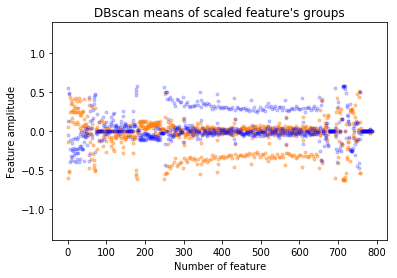

In [166]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan means of scaled feature's groups")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

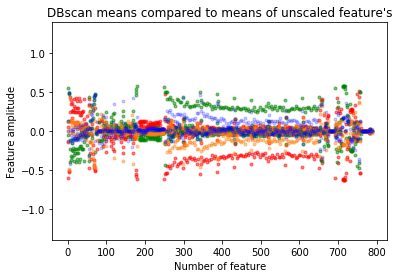

In [167]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan means compared to means of unscaled feature's")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

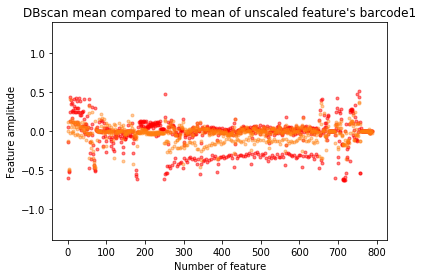

In [168]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan mean compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.show()

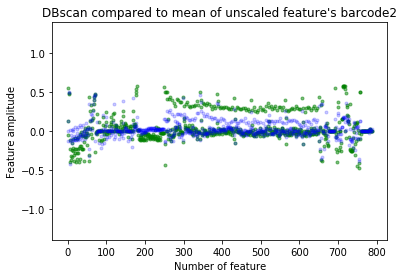

In [169]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan compared to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

[Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering), didnt find intuition for the algorithm, on scaled data:

In [173]:
spectral=SpectralClustering(n_clusters=2)
spectral.fit(scaled_F)

C:\Users\Elad\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

Accuracy of prediction in probabilities, and calculating corresponding centers:

In [174]:
center1=None
center2=None

prob1=np.sum(spectral.labels_[:760])/760
prob2=1-np.sum(spectral.labels_[760:])/757

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=np.mean(scaled_F[spectral.labels_==1],axis=0)
    center2=np.mean(scaled_F[spectral.labels_==0],axis=0)
else:
    print (1-prob1,1-prob2)
    center1=np.mean(scaled_F[spectral.labels_==0],axis=0)
    center2=np.mean(scaled_F[spectral.labels_==1],axis=0)

0.95 0.20079260237780716


Plotting data:

In [175]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

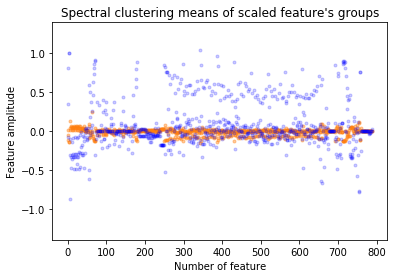

In [176]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering means of scaled feature's groups")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

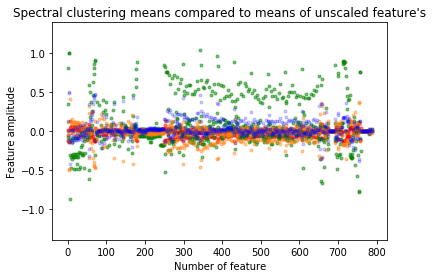

In [177]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering means compared to means of unscaled feature's")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

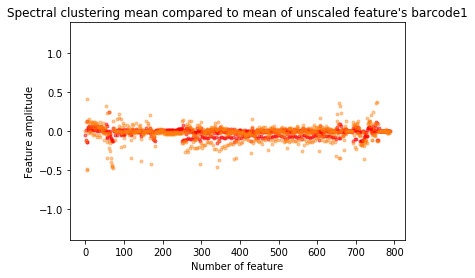

In [178]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering mean compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean1.shape[0]),scaled_mean1,'C1.',alpha=0.4)
plt.show()

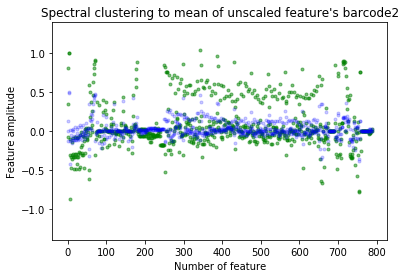

In [179]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean2.shape[0]),scaled_mean2,'b.',alpha=0.2)
plt.show()

Conclusions:
------------

We see these algorithms have an okay accuracy when applied on the features extracted from the signals, specifically DBscan.
In addition, we see the main difference between the groups in these parameters:

In [126]:
features1.columns[250:650]

Index(['Signal__fft_aggregated__aggtype_"centroid"',
       'Signal__fft_aggregated__aggtype_"kurtosis"',
       'Signal__fft_aggregated__aggtype_"skew"',
       'Signal__fft_aggregated__aggtype_"variance"',
       'Signal__fft_coefficient__coeff_0__attr_"abs"',
       'Signal__fft_coefficient__coeff_0__attr_"angle"',
       'Signal__fft_coefficient__coeff_0__attr_"imag"',
       'Signal__fft_coefficient__coeff_0__attr_"real"',
       'Signal__fft_coefficient__coeff_10__attr_"abs"',
       'Signal__fft_coefficient__coeff_10__attr_"angle"',
       ...
       'Signal__fft_coefficient__coeff_97__attr_"imag"',
       'Signal__fft_coefficient__coeff_97__attr_"real"',
       'Signal__fft_coefficient__coeff_98__attr_"abs"',
       'Signal__fft_coefficient__coeff_98__attr_"angle"',
       'Signal__fft_coefficient__coeff_98__attr_"imag"',
       'Signal__fft_coefficient__coeff_98__attr_"real"',
       'Signal__fft_coefficient__coeff_99__attr_"abs"',
       'Signal__fft_coefficient__coeff_99__at

Checking to see if similiar aproach works on separating pass and fails:
-----------------------------------------------------------------------
I decided to not normalize the data again, to make it easier to compare with what has been done before. This may effect results significantly.

Calculating means of pass and fails for each barcode:

In [23]:
scaled_mean_barcode1_pass=np.mean(scaled_F[:380],axis=0)
scaled_mean_barcode1_fail=np.mean(scaled_F[380:760],axis=0)
scaled_mean_barcode2_pass=np.mean(scaled_F[760:1138],axis=0)
scaled_mean_barcode2_fail=np.mean(scaled_F[1149:],axis=0)

(380, 789) (380, 789) (378, 789) (379, 789)


Analysis of barcode1:

Plotting data:

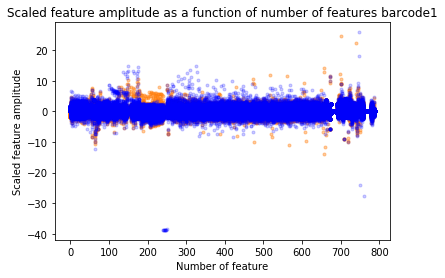

In [26]:
plt.figure()

plt.title("Scaled feature amplitude as a function of number of features barcode1")
plt.ylabel("Scaled feature amplitude")
plt.xlabel("Number of feature")
plt.plot(np.broadcast_to(np.arange(scaled_F.shape[1]),(380,scaled_F.shape[1])),scaled_F[:380],'C1.',alpha=0.4)
plt.plot(np.broadcast_to(np.arange(scaled_F.shape[1]),(380,scaled_F.shape[1])),scaled_F[380:760],'b.',alpha=0.2)
plt.show()

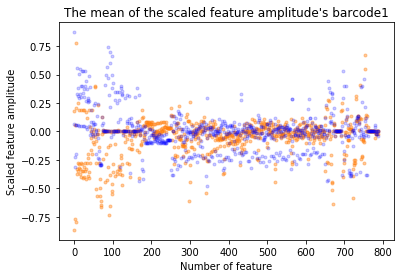

In [28]:
plt.figure()

plt.title("The mean of the scaled feature amplitude's barcode1")
plt.ylabel("Scaled feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

[K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) on scaled data of pass and fail of barcode1:

In [32]:
scaled_kmeans=KMeans(n_clusters=2)
scaled_kmeans.fit(scaled_F[:760])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [33]:
scaled_kmeans.cluster_centers_

array([[ 0.63741897,  0.12767775, -1.21575214, ...,  0.        ,
         0.22790816,  0.        ],
       [-0.29277481,  0.11956364,  0.37759887, ...,  0.        ,
        -0.1473167 ,  0.        ]])

Accuracy of prediction in probabilities, and finding corresponding centers to groups:

In [34]:
center1=None
center2=None

prob1=np.sum(scaled_kmeans.predict(scaled_F[:380]))/380
prob2=1-np.sum(scaled_kmeans.predict(scaled_F[380:760]))/380

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=scaled_kmeans.cluster_centers_[1]
    center2=scaled_kmeans.cluster_centers_[0]
else:
    print (1-prob1,1-prob2)
    center1=scaled_kmeans.cluster_centers_[0]
    center2=scaled_kmeans.cluster_centers_[1]

0.9026315789473685 0.5394736842105263


Plotting data:

In [35]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

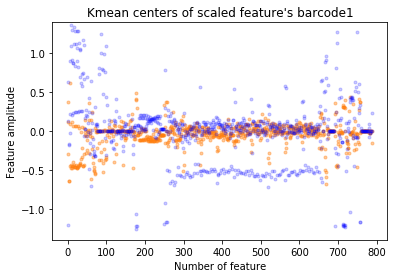

In [38]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean centers of scaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

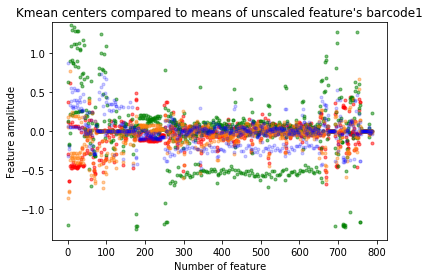

In [39]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean centers compared to means of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

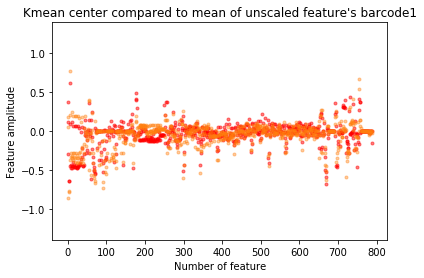

In [40]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean center compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.show()

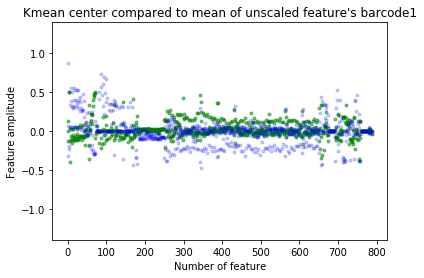

In [69]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean center compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

[DBscan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), an unsupervised clustering algorithm based on finding dense clusters and the "vacums" between them, on scaled data:

In [44]:
dbscan=DBSCAN(eps=25)
dbscan.fit(scaled_F[:760])

DBSCAN(algorithm='auto', eps=25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Accuracy of prediction in probabilities, and calculating corresponding centers:

In [46]:
center1=None
center2=None

prob1=np.sum(dbscan.labels_[:380])/380*-1
prob2=1-np.sum(dbscan.labels_[380:760])/380*-1

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=np.mean(scaled_F[:760][dbscan.labels_==1],axis=0)
    center2=np.mean(scaled_F[:760][dbscan.labels_==0],axis=0)
else:
    print (1-prob1,1-prob2)
    center1=np.mean(scaled_F[:760][dbscan.labels_==0],axis=0)
    center2=np.mean(scaled_F[:760][dbscan.labels_==-1],axis=0)

0.6526315789473685 0.3526315789473684


Plotting data:

In [294]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

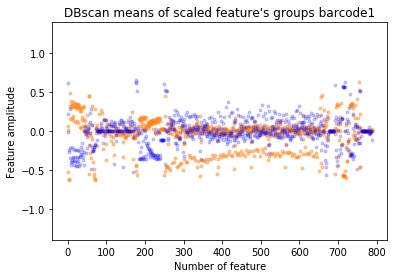

In [47]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan means of scaled feature's groups barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

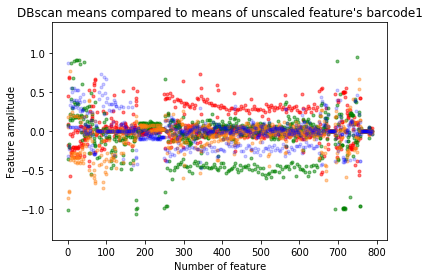

In [88]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan means compared to means of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

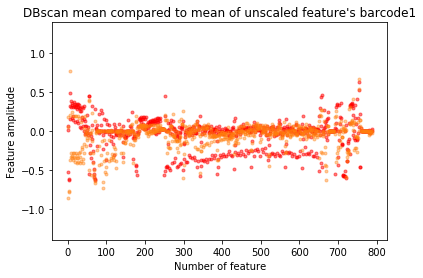

In [49]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan mean compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.show()

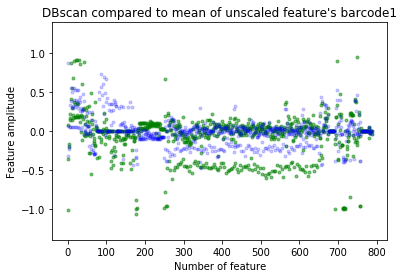

In [86]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

[Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering), didnt find intuition for the algorithm, on scaled data:

In [51]:
spectral=SpectralClustering(n_clusters=2)
spectral.fit(scaled_F[:760])

C:\Users\Elad\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

Accuracy of prediction in probabilities, and calculating corresponding centers:

In [52]:
center1=None
center2=None

prob1=np.sum(spectral.labels_[:380])/380
prob2=1-np.sum(spectral.labels_[380:760])/380

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=np.mean(scaled_F[:760][spectral.labels_==1],axis=0)
    center2=np.mean(scaled_F[:760][spectral.labels_==0],axis=0)
else:
    print (1-prob1,1-prob2)
    center1=np.mean(scaled_F[:760][spectral.labels_==0],axis=0)
    center2=np.mean(scaled_F[:760][spectral.labels_==1],axis=0)

0.9736842105263158 0.047368421052631615


Plotting data:

In [53]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

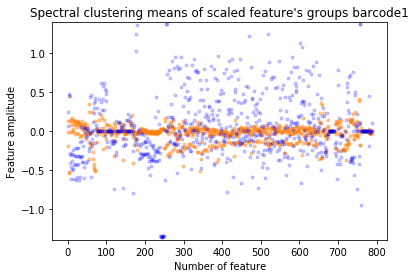

In [54]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering means of scaled feature's groups barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

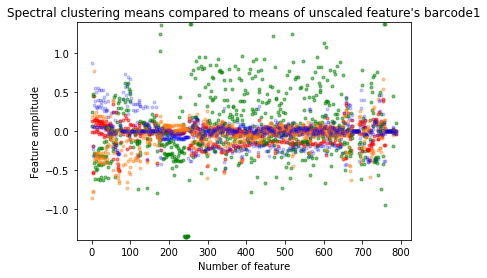

In [55]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering means compared to means of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

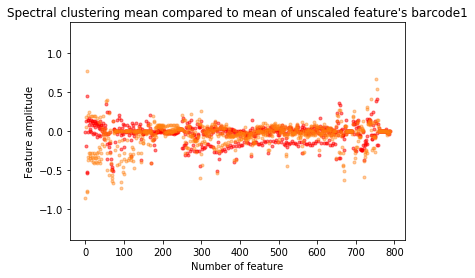

In [56]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering mean compared to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_pass.shape[0]),scaled_mean_barcode1_pass,'C1.',alpha=0.4)
plt.show()

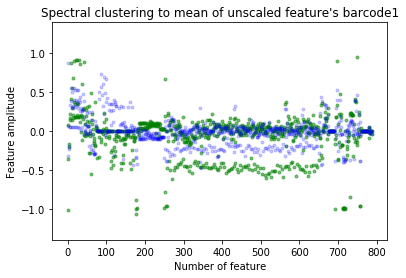

In [87]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Spectral clustering to mean of unscaled feature's barcode1")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode1_fail.shape[0]),scaled_mean_barcode1_fail,'b.',alpha=0.2)
plt.show()

Analysis of barcode2:

Plotting data:

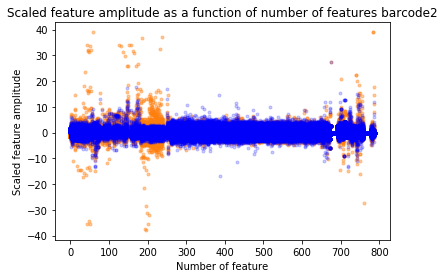

In [58]:
plt.figure()

plt.title("Scaled feature amplitude as a function of number of features barcode2")
plt.ylabel("Scaled feature amplitude")
plt.xlabel("Number of feature")
plt.plot(np.broadcast_to(np.arange(scaled_F.shape[1]),(378,scaled_F.shape[1])),scaled_F[760:1138],'C1.',alpha=0.4)
plt.plot(np.broadcast_to(np.arange(scaled_F.shape[1]),(379,scaled_F.shape[1])),scaled_F[1138:],'b.',alpha=0.2)
plt.show()

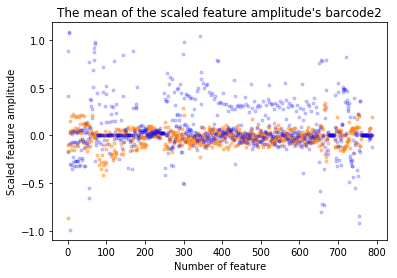

In [59]:
plt.figure()

plt.title("The mean of the scaled feature amplitude's barcode2")
plt.ylabel("Scaled feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(scaled_mean_barcode2_pass.shape[0]),scaled_mean_barcode2_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode2_fail.shape[0]),scaled_mean_barcode2_fail,'b.',alpha=0.2)
plt.show()

[K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) on scaled data of pass and fail of barcode1:

In [60]:
scaled_kmeans=KMeans(n_clusters=2)
scaled_kmeans.fit(scaled_F[760:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [61]:
scaled_kmeans.cluster_centers_

array([[ 1.89295075e-01, -8.83751234e-02, -4.87277409e-02, ...,
         0.00000000e+00,  1.05798061e+01,  0.00000000e+00],
       [-4.71344841e-03, -1.22859182e-01,  1.31462026e-01, ...,
         0.00000000e+00, -4.22111124e-02,  0.00000000e+00]])

Accuracy of prediction in probabilities, and finding corresponding centers to groups:

In [64]:
center1=None
center2=None

prob1=np.sum(scaled_kmeans.predict(scaled_F[760:1138]))/378
prob2=1-np.sum(scaled_kmeans.predict(scaled_F[1138:]))/379

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=scaled_kmeans.cluster_centers_[1]
    center2=scaled_kmeans.cluster_centers_[0]
else:
    print (1-prob1,1-prob2)
    center1=scaled_kmeans.cluster_centers_[0]
    center2=scaled_kmeans.cluster_centers_[1]

0.007936507936507908 0.9947229551451188


Plotting data:

In [35]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

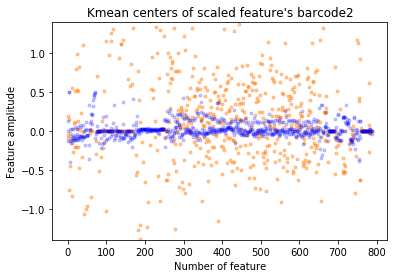

In [65]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean centers of scaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

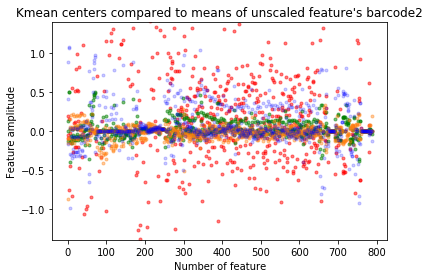

In [66]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean centers compared to means of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode2_pass.shape[0]),scaled_mean_barcode2_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode2_fail.shape[0]),scaled_mean_barcode2_fail,'b.',alpha=0.2)
plt.show()

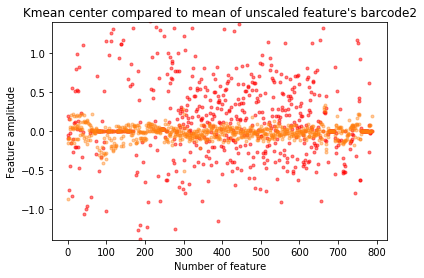

In [67]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean center compared to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean_barcode2_pass.shape[0]),scaled_mean_barcode2_pass,'C1.',alpha=0.4)
plt.show()

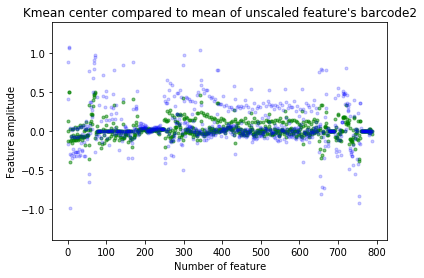

In [68]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("Kmean center compared to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode2_fail.shape[0]),scaled_mean_barcode2_fail,'b.',alpha=0.2)
plt.show()

[DBscan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), an unsupervised clustering algorithm based on finding dense clusters and the "vacums" between them, on scaled data:

In [76]:
dbscan=DBSCAN(eps=25)
dbscan.fit(scaled_F[760:])

DBSCAN(algorithm='auto', eps=25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Accuracy of prediction in probabilities, and calculating corresponding centers:

In [78]:
center1=None
center2=None

prob1=np.sum(dbscan.labels_[760:1138])/378*-1
prob2=1-np.sum(dbscan.labels_[1138:])/379*-1

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=np.mean(scaled_F[760:][dbscan.labels_==-1],axis=0)
    center2=np.mean(scaled_F[760:][dbscan.labels_==0],axis=0)
else:
    print (1-prob1,1-prob2)
    center1=np.mean(scaled_F[760:][dbscan.labels_==0],axis=0)
    center2=np.mean(scaled_F[760:][dbscan.labels_==-1],axis=0)

-0.0 1.0


Plotting data:

In [79]:
#parameters for consistent graphs

ymin,ymax=-1.4,1.4

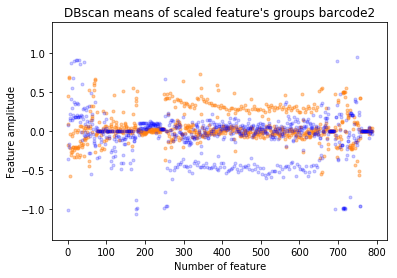

In [81]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan means of scaled feature's groups barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'C1.',alpha=0.4)
plt.plot(range(center2.shape[0]),center2,'b.',alpha=0.2)
plt.show()

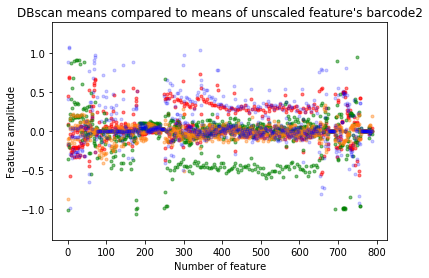

In [82]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan means compared to means of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode2_pass.shape[0]),scaled_mean_barcode2_pass,'C1.',alpha=0.4)
plt.plot(range(scaled_mean_barcode2_fail.shape[0]),scaled_mean_barcode2_fail,'b.',alpha=0.2)
plt.show()

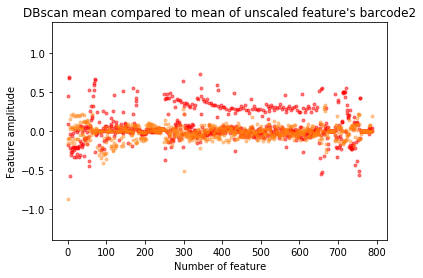

In [83]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan mean compared to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(scaled_mean_barcode2_pass.shape[0]),scaled_mean_barcode2_pass,'C1.',alpha=0.4)
plt.show()

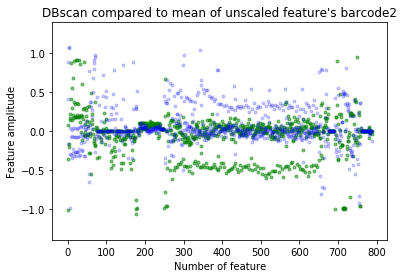

In [84]:
plt.figure()

plt.ylim(ymin,ymax)
plt.title("DBscan compared to mean of unscaled feature's barcode2")
plt.ylabel("Feature amplitude")
plt.xlabel("Number of feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(scaled_mean_barcode2_fail.shape[0]),scaled_mean_barcode2_fail,'b.',alpha=0.2)
plt.show()

[Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering), 
for some reason didn't work on this data.

Third approach - Using an Autoencoder DNN to find relevant features
-------------------------------------------------------------------

Since there are a significant number of features, and probably not all of them are relevant, there is a need to find the relevant features. This can be done using PCA ([Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)), however this will only find linear relations. To find non-linear relations, it is possible to use [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder) DNN's (Deep Neural Networks). To give some intuition on how this works, I'll briefly compare "normal" DNN's ([MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron)) to autoencoders. 

An MLP's operation on an feature tensor $x$ can be defined as:

$\hat y=f_n(W_n(f_{n-1}(W_{n-1}( \cdots f_1(W_1(x)) \cdots )$

With $\hat y$ ,which is a tensor, as the prediction of the network, $f_i$ as the [activation function](https://en.wikipedia.org/wiki/Activation_function) of the $i_{th}$ layer and $W_i$ ,which is tensor, as the weights of the $i_{th}$ layer. Visually, you can imagine it like so:

![](http://pubs.sciepub.com/ajmm/3/3/1/bigimage/fig5.png)

Where the input is $x$ and the output is $\hat y$. Now, imagine that the layers instead of expanding in the middle actuallly shrink, and then expand again? Like this:

![](https://cdn-images-1.medium.com/max/1600/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

The network will encode the data in a non-linear fashion, and then decode it! 

Implementation:
---------------

I programed and trained an autoencoder on the data, using pytorch, an state of the art deep learning framework backed by Facebook, and then clustered it with some of the algorithms listed above.

In [182]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F

Defining the Aoutoencoder:

In [183]:
class autoencoder(nn.Module):
    
    def __init__(self,o_lin1_size,o_lin2_size,o_lin3_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(789, o_lin1_size),
            nn.ReLU(True),
            nn.Linear(o_lin1_size, o_lin2_size),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(o_lin2_size, o_lin3_size),
            nn.ReLU(True),
            nn.Linear(o_lin3_size, 789),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Defining hyperparameters and telling the computer to use the gpu if it is avaiable (per requirements):

In [189]:
from IPython.display import clear_output

num_epochs = 2000
batch_size = int(scaled_F.shape[0]/4)
learning_rate = 1e-3
    
device=("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Using "+device)

Using cuda:0


Prepping data:

In [190]:
tensor_F=torch.tensor(scaled_F,dtype=torch.float).to(device)
dataloader = DataLoader(tensor_F, batch_size=batch_size, shuffle=True)

Training model and finding optimal layer sizes:

In [ ]:
criterion = nn.MSELoss().to(device)
loss_tensor=np.empty((8,4,8,num_epochs))
min_loss=np.inf
parameters=None


for lin_size1 in range(500,4001,500):
    for lin_size2 in range(50,201,50):
        for lin_size3 in range(500,4001,500):
            clear_output(wait=True)
            model = autoencoder(lin_size1,lin_size2,lin_size3).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
            
            for epoch in range(num_epochs):
                for data in dataloader:
                    # ===================forward=====================
                    output = model(data)
                    loss = criterion(output, data)
                    loss_tensor[int((lin_size1-500)/500),int((lin_size2-50)/50),int((lin_size3-500)/500),epoch]=loss#loss in appropriate position
                    #====================check if best version=======
                    if loss<min_loss:
                        min_loss=loss
                        parameters=model.state_dict()
                    # ===================backward====================
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # ===================log========================
                print('With lin_size1, lin_size2, lin_size3 equals: {},{},{}, epoch [{}/{}], loss:{:.4f}'
                      .format(lin_size1, lin_size2, lin_size3, epoch + 1, num_epochs, loss.data))

torch.save(parameters, './feature_autoencoder.txt')

In [20]:
#np.save('./loss_tensor',loss_l)

Loading the model:

In [184]:
parameters=torch.load('./feature_autoencoder.txt')

In [185]:
o_lin1_size=parameters['encoder.0.bias'].shape[0]
o_lin2_size=parameters['encoder.2.bias'].shape[0]
o_lin3_size=parameters['decoder.0.bias'].shape[0]

print (o_lin1_size,o_lin2_size,o_lin3_size)

4000 100 4000


In [186]:
opt_model = autoencoder(o_lin1_size,o_lin2_size,o_lin3_size)
opt_model.load_state_dict(parameters)

Using the Autoencoder to encode the data:

In [191]:
ae_F=opt_model.encoder(tensor_F.to('cpu')).detach().numpy()

In [192]:
ae_mean1=np.mean(ae_F[:760],axis=0)
ae_mean2=np.mean(ae_F[760:],axis=0)

Applying K-means:

In [193]:
ae_kmeans=KMeans(n_clusters=2)
ae_kmeans.fit(ae_F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Accuracy of prediction in probabilities, and finding corresponding centers to groups:

In [194]:
center1=None
center2=None

prob1=np.sum(ae_kmeans.predict(ae_F[:760]))/760
prob2=1-np.sum(ae_kmeans.predict(ae_F[760:]))/757

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
    center1=ae_kmeans.cluster_centers_[1]
    center2=ae_kmeans.cluster_centers_[0]
else:
    print (1-prob1,1-prob2)
    center1=ae_kmeans.cluster_centers_[0]
    center2=ae_kmeans.cluster_centers_[1]

0.9144736842105263 0.32100396301188905


Plotting data:

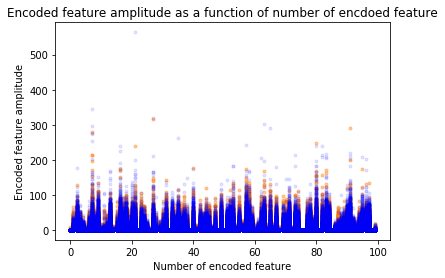

In [195]:
plt.figure()

plt.title("Encoded feature amplitude as a function of number of encdoed feature")
plt.ylabel("Encoded feature amplitude")
plt.xlabel("Number of encoded feature")
plt.plot(np.broadcast_to(np.arange(ae_F.shape[1]),(760,ae_F.shape[1])),ae_F[:760],'C1.',alpha=0.4)
plt.plot(np.broadcast_to(np.arange(ae_F.shape[1]),(757,ae_F.shape[1])),ae_F[760:],'b.',alpha=0.1)
plt.show()

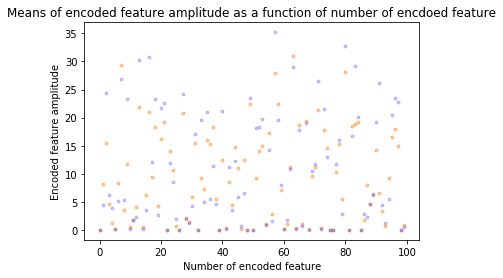

In [196]:
plt.figure()

plt.title("Means of encoded feature amplitude as a function of number of encdoed feature")
plt.ylabel("Encoded feature amplitude")
plt.xlabel("Number of encoded feature")
plt.plot(range(ae_mean1.shape[0]),ae_mean1,'C1.',alpha=0.4)
plt.plot(range(ae_mean2.shape[0]),ae_mean2,'b.',alpha=0.2)
plt.show()

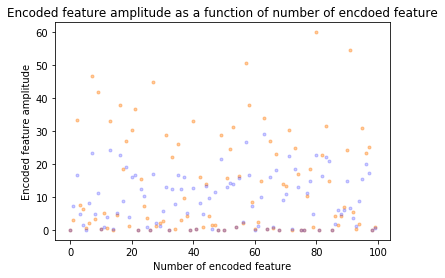

In [197]:
plt.figure()

plt.title("Encoded feature amplitude as a function of number of encdoed feature")
plt.ylabel("Encoded feature amplitude")
plt.xlabel("Number of encoded feature")
plt.plot(range(ae_kmeans.cluster_centers_.shape[1]),ae_kmeans.cluster_centers_[0],'C1.',alpha=0.4)
plt.plot(range(ae_kmeans.cluster_centers_.shape[1]),ae_kmeans.cluster_centers_[1],'b.',alpha=0.2)
plt.show()

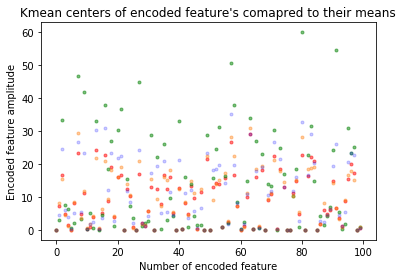

In [198]:
plt.figure()

plt.title("Kmean centers of encoded feature's comapred to their means")
plt.ylabel("Encoded feature amplitude")
plt.xlabel("Number of encoded feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=0.5)
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.5)
plt.plot(range(ae_mean1.shape[0]),ae_mean1,'C1.',alpha=0.4)
plt.plot(range(ae_mean2.shape[0]),ae_mean2,'b.',alpha=0.2)
plt.show()

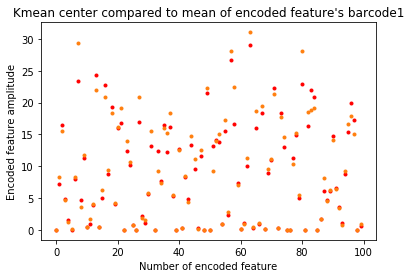

In [199]:
plt.figure()

plt.title("Kmean center compared to mean of encoded feature's barcode1")
plt.ylabel("Encoded feature amplitude")
plt.xlabel("Number of encoded feature")
plt.plot(range(center1.shape[0]),center1,'r.',alpha=1)
plt.plot(range(ae_mean1.shape[0]),ae_mean1,'C1.',alpha=1)
plt.show()

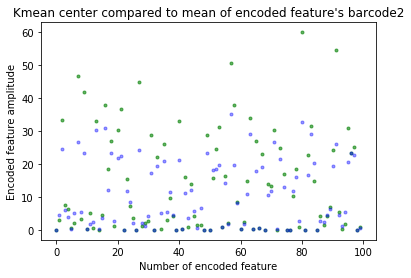

In [200]:
plt.figure()

plt.title("Kmean center compared to mean of encoded feature's barcode2")
plt.ylabel("Encoded feature amplitude")
plt.xlabel("Number of encoded feature")
plt.plot(range(center2.shape[0]),center2,'g.',alpha=0.6)
plt.plot(range(ae_mean2.shape[0]),ae_mean2,'b.',alpha=0.4)
plt.show()

Conclusions:
------------

There appears to be a slight improvement over clustering it normally, didnt check all relevant algorithms, however doesnt help in identifying relevant feautures, so probably not correct aproach.

An Interesting Obversation:
---------------------------

If you change the clusters generated by multiplying by -1 better results emerge.

In [340]:
kmeans_t=KMeans(n_clusters=2)
kmeans_t.fit(F)
kmeans_t.cluster_centers_[0]=-scaled_kmeans.cluster_centers_[0]
kmeans_t.cluster_centers_[1]=-scaled_kmeans.cluster_centers_[1]

In [341]:
prob1=np.sum(kmeans_t.predict(scaled_F[:760]))/760
prob2=1-np.sum(kmeans_t.predict(scaled_F[760:]))/757

if (prob1+prob2)>=(2-prob1-prob2):
    print (prob1,prob2)
else:
    print (1-prob1,1-prob2)

0.7539473684210526 0.5178335535006605


Fourth approach - Linear classifiers for finding important features
-------------------------------------------------------------------

Since the main reason for applying unsuprevised learning is to find features that are relevant to the problem, interpretable suprevised classifiers may also be used. 

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

Assigning labels and creating train and test data:

In [92]:
y=np.concatenate((np.ones(760),np.zeros(757)))

In [93]:
d=np.column_stack((scaled_F,y))
np.random.shuffle(d)

scaled_F_train,scaled_F_test,y_train,y_test=d[:1200,:-1],d[1200:,:-1],d[:1200,-1],d[1200:,-1]

[SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with linear kernel, it can be viewed as trying to find the the hyperplane which separates the data with maximal margins. Here is a gif of training a linear svm where the data is two dimensional:

![](https://jeremykun.files.wordpress.com/2017/06/svm_solve_by_hand-e1496076457793.gif)

And here is a result in three dimensions:

![](https://cdn-images-1.medium.com/max/800/0*Ojchw_Exefs4qiok.)

In [94]:
clf=svm.SVC(verbose=True,kernel='linear')

In [95]:
clf.fit(scaled_F_train,y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [96]:
print ("Probability of correct prediction: "+str(1-np.sum(np.abs(clf.predict(scaled_F_test)-y_test))/y_test.shape[0]))

Probability of correct prediction: 0.7350157728706624


In [105]:
coefs=np.squeeze(clf.coef_)

(789,)

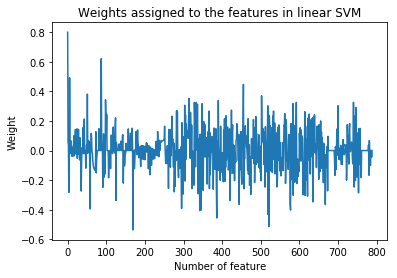

In [106]:
plt.figure()
plt.plot(range(coefs.shape[0]),coefs)
plt.title("Weights assigned to the features in linear SVM")
plt.ylabel("Weight")
plt.xlabel("Number of feature")
plt.show()

[Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), a classic machine learning algorithm, finds the hyperplane which describing parameters have maximum likelihood given the data.

In [100]:
logreg=LogisticRegression()

In [101]:
logreg.fit(scaled_F_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
print ("Probability of correct prediction: "+str(1-np.sum(np.abs(logreg.predict(scaled_F_test)-y_test))/y_test.shape[0]))

Probability of correct prediction: 0.7476340694006309


In [103]:
coefs=np.squeeze(logreg.coef_)

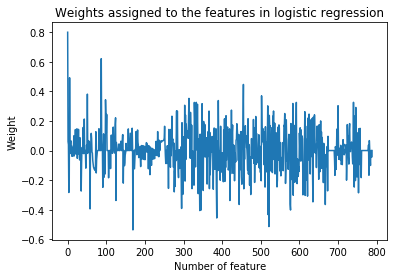

In [107]:
plt.figure()
plt.title("Weights assigned to the features in logistic regression")
plt.ylabel("Weight")
plt.xlabel("Number of feature")
plt.plot(range(coefs.shape[0]),coefs)
plt.show()

Additional approaches:
------------------------

1.Unsupervised clustering via deep learning based on this [paper](https://arxiv.org/pdf/1801.07648.pdf), which contains various methods of doing so.

2.This [package](https://github.com/marcotcr/lime).

3.This [paper](https://www.biorxiv.org/content/biorxiv/early/2018/11/06/463463.full.pdf)

Other important resources:
---------------------------
[Github page comparing different basecallers](https://github.com/rrwick/Basecalling-comparison)